In [1]:
import numpy as np 
import pandas as pd
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import linear_model, datasets
from sklearn.linear_model import RandomizedLogisticRegression
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

from util.custom_lib import *

In [2]:
dw = DataWrangler()
df = dw.read_csv_to_df('data/creditcard.csv')
n_sample, n_feature = df.shape
print (n_sample, n_feature)

284807 31


In [4]:
print(df.head())
class_index = n_feature-1 # 'Class'

new_df = dw.label_imbalance_check_fix(df, 'Class', verbose=True)
print(new_df.shape)

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...         V21       V22       V23       V24  \
0  0.098698  0.363787  ...   -0.018307  0.277838 -0.110474  0.066928   
1  0.085102 -0.255425  ...   -0.225775 -0.638672  0.101288 -0.339846   
2  0.247676 -1.514654  ...    0.247998  0.771679  0.909412 -0.689281   
3  0.377436 -1.387024  ...   -0.108300  0.005274 -0.190321 -1.175575   
4 -0.270533  0.817739  ...   -0.009431  0.798278 -0.137458  0.141267   

        V25       V26       V27       V28  Amount  Class  
0  0.128539 -0.189115

## Balancing Data

0    284315
1       492
Name: Class, dtype: int64
0    0.998273
1    0.001727
Name: Class, dtype: float64
0.00172748563062 0.998272514369
0 0.998272514369
1 0.00172748563062


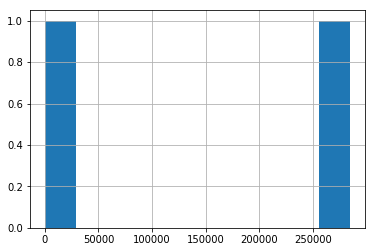

In [14]:
# check label imbalancedness
print(df['Class'].value_counts())
df['Class'].value_counts().hist()
print(df['Class'].value_counts()/df.shape[0])
ratios = df['Class'].value_counts()/df.shape[0]
print(ratios.min(), ratios.max())
for l, r in list(zip(ratios.index, ratios.values)):
    print(l, r)

In [6]:
fraud_raw = df[df['Class'] == 1]
normal_raw = df[df['Class'] == 0]

# undersample the normal
ratio = fraud_raw.shape[0]/float(normal_raw.shape[0])
print(ratio)
normal = normal_raw.sample(frac=ratio)
fraud = fraud_raw
df_new, splits = dw.stack_dfs([fraud, normal])
print(splits)

0.0017304750013189597
[492]


             precision    recall  f1-score   support

        0.0       0.93      0.98      0.95       156
        1.0       0.98      0.91      0.94       140

avg / total       0.95      0.95      0.95       296



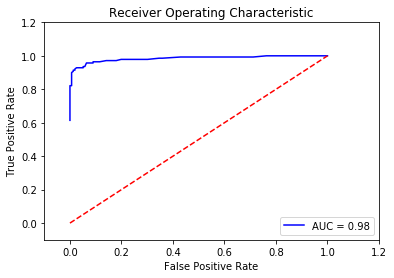

In [8]:
reg_model = RandomForestClassifier(criterion='entropy', n_estimators=100)
train_data, test_data = train_test_split(df_new, test_size=0.3)
train_matrix = train_data.as_matrix()
x = train_matrix[:, range(0,class_index-1)]
y = train_matrix[:,class_index]
reg_model = reg_model.fit(x,y)

test_matrix =test_data.as_matrix()
test_x = test_matrix[:,range(0,class_index-1)]
test_y = test_matrix[:,class_index]

predicted = reg_model.predict(test_x)
predicted_proba = reg_model.predict_proba(test_x)

print(metrics.classification_report(test_y, predicted))
#print(metrics.confusion_matrix(test_y, predicted))
false_positive_rate, true_positive_rate, thresholds = roc_curve(test_y, predicted_proba[:,1])
roc_auc = auc(false_positive_rate, true_positive_rate)
#print('AUC = %0.4f'% roc_auc)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()